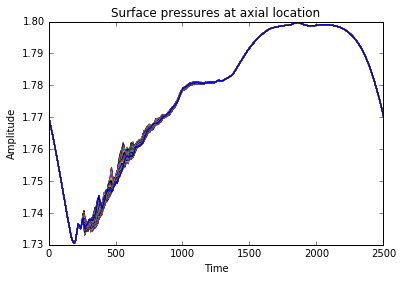

In [2]:
"""
Dynamic Stall of Plunging Airfoil
"""

import numpy as np
import h5py
import matplotlib.pyplot as plt
%matplotlib inline

g1 = h5py.File('surfPHighResdynStall.mat','r') 
g1.keys()

spDS= g1.get('surfP')

""" Plot DS Surface Pressures at different locations in the leading
edge, at adjacent grid points """
xloc= 10
zloc = 10
for i in range(1,100):
    plt.plot(spDS[:,i,xloc])

plt.title('Surface pressures at axial location')
plt.xlabel('Time')
plt.ylabel('Amplitude')

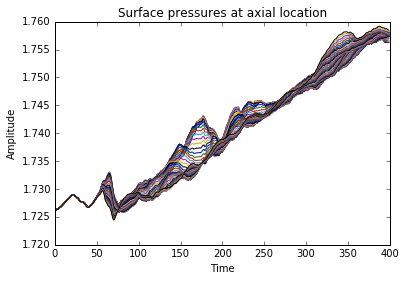

In [5]:

""" Plot DS Surface Pressures at different locations in the leading
edge, at adjacent grid points """
xloc= 5
zloc = 10
tlen = 600
numpoints = 50
timevec = np.linspace(200.005,tlen*0.005,tlen)
for i in range(1,numpoints):
    plt.plot(spDS[200:tlen,i,xloc])

plt.title('Surface pressures at axial location')
plt.xlabel('Time')
plt.ylabel('Amplitude')

(400,)


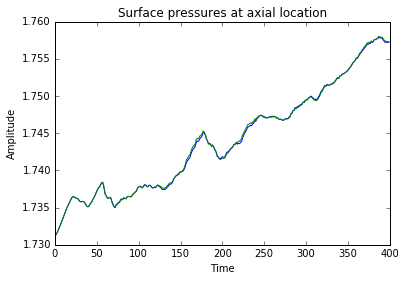

In [12]:

""" Plot DS Surface Pressures at different locations in the leading
edge, at adjacent grid points """
xloc= 10
zloc = 10
tlen = 600
numpoints = 3
timevec = np.linspace(200.005,tlen*0.005,tlen)
for i in range(1,numpoints):
    plt.plot(spDS[200:tlen,i,xloc])

plt.title('Surface pressures at axial location')
plt.xlabel('Time')
plt.ylabel('Amplitude')

#save data for deep learning
dat = spDS[200:tlen,2,10]
print(dat.shape)
np.save('dynStallInception',dat)

In [7]:
import keras

Using TensorFlow backend.


In [8]:

"""
Static Stall with and w/o control
"""

f1 = h5py.File('surfaceP_NC.mat','r') 
f2 = h5py.File('surfaceP_C.mat','r') 
f1.keys()
f2.keys()
# check keys name to get stored variable name
# Here, it is surfPNC
# Finally, extract the array data from the HDF5 files
spNC= f1.get('surfPNC')
spC = f2.get('surfPC')

In [9]:
spNC

<HDF5 dataset "surfPNC": shape (600, 322), type "<f8">

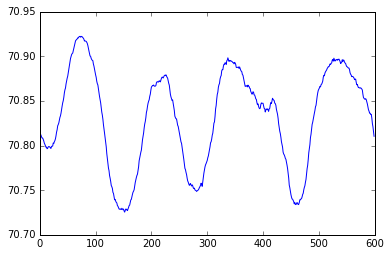

In [11]:
plt.plot(spNC[:,5])

In [33]:
np.save('NACA0012stalled',spNC[:,5])

In [34]:
a = np.load('NACA0012stalled.npy')

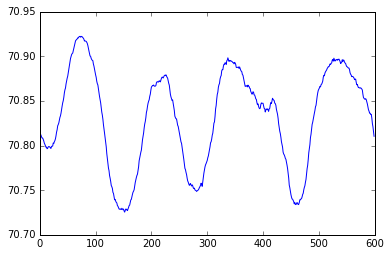

In [36]:
plt.plot(a)

In [15]:
a = np.load('dynStallInception.npy')

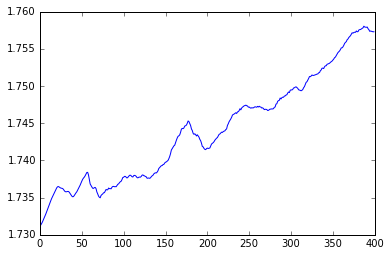

In [16]:
plt.plot(a)
plt.show()

In [1]:
"""
How to format data from multiple signals
for LSTM input
"""
import sys
import numpy as np
import h5py
import time
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils

def plot_data(data):
    plt.plot(data,'o')
    plt.title('Signal')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.show()

def downsample(data, n_points):
    """ downsample every 'n' points """
    new_data = data[0:-1:n_points]
    return new_data
    
def define_states(data, n_states):
    """ Define bounds for each state """
    data_lowbound = np.min(data)
    data_highbound = np.max(data)
    print('Signal Min/Max:', data_lowbound, data_highbound)
    data_span = data_highbound - data_lowbound
    state_window = data_span/n_states
    lbound = []
    ubound = []
    state_id = []
    for i in range(n_states):
        state_id.append(i)
        lbound.append(data_lowbound + (i*state_window))
        ubound.append(data_lowbound + ((i+1)*state_window))
        
    state_boundaries = list(zip(state_id,lbound,ubound))
    return state_boundaries
    
def create_states(data, state_boundaries):
    """ identify states in the signal """
    states = []
    sig_len = len(data)
    #print(sig_len)
    for i in range(0,sig_len):
        #print(i)
        dataPoint = data[i]
        #print(dataPoint)
        for j in range(len(state_boundaries)):
            if (dataPoint > state_boundaries[j][1] \
                and dataPoint <= state_boundaries[j][2]):
                states.append(state_boundaries[j][0])
                #print(state_boundaries[j][0])
                break
    return states        


def signal_convert(dat, state_boundaries):
    rawSignal=[]
    datlen = len(dat)
    #print('len', datlen)
    for i in range(0,datlen-1):
        #print('i is', i)
        ind = dat[i]
        #print('index', ind)
        temp = 0.5*(state_boundaries[ind][1] + state_boundaries[ind][2])
        rawSignal.append(temp)
        #print('aa is', temp)
    
    return rawSignal


def generate_noisy_seed(data, state_boundaries, SNR):
    signal = map_to_signal(data, state_boundaries)
    noise = np.random.normal(0, 1, len(signal))*(1.0/SNR)
    noisy_signal = signal + noise
    noise_state_signal = create_states(noisy_signal, state_boundaries)
    return noise_state_signal
    
    
    
""" 
Read Data
 
"""

inputData = np.load('dynStallTrainingData.npy')
print(('Shape', inputData.shape))   

#xinp = np.linspace(-np.pi, 8*np.pi, 201)
#inputData = np.sin(xinp)
#print('Shape', inputData.shape)  
    
"""
Main Code
"""
# INPUT
n_states = 250
seq_length = 25
# load the network weights
filename = "weights_case3_r5.hdf5"

state_boundaries = define_states(inputData, n_states)
states = create_states(inputData, state_boundaries)    
# prepare the dataset of input to output pairs encoded as integers
dataX = []
dataY = []
for i in range(0, len(states) - seq_length, 1):
	seq_in = states[i:i + seq_length]
	seq_out = states[i + seq_length]
	dataX.append(seq_in)
	dataY.append(seq_out)
n_patterns = len(dataX)
print("Total Patterns: ", n_patterns)
    
    
# reshape X to be [samples, time steps, features]
X = np.reshape(dataX, (n_patterns, seq_length, 1))
# normalize
X = X / float(n_states)
# one hot encode the output variable
y = np_utils.to_categorical(dataY)

Using TensorFlow backend.


('Shape', (133,))
Signal Min/Max: 1.73112261295 1.7580395937
Total Patterns:  107


In [4]:
print(dataX)

[[5, 13, 21, 29, 37, 44, 49, 48, 47, 43, 43, 41, 37, 40, 45, 51, 58, 63, 67, 53, 47, 48, 40, 35, 40], [13, 21, 29, 37, 44, 49, 48, 47, 43, 43, 41, 37, 40, 45, 51, 58, 63, 67, 53, 47, 48, 40, 35, 40, 44], [21, 29, 37, 44, 49, 48, 47, 43, 43, 41, 37, 40, 45, 51, 58, 63, 67, 53, 47, 48, 40, 35, 40, 44, 45], [29, 37, 44, 49, 48, 47, 43, 43, 41, 37, 40, 45, 51, 58, 63, 67, 53, 47, 48, 40, 35, 40, 44, 45, 47], [37, 44, 49, 48, 47, 43, 43, 41, 37, 40, 45, 51, 58, 63, 67, 53, 47, 48, 40, 35, 40, 44, 45, 47, 49], [44, 49, 48, 47, 43, 43, 41, 37, 40, 45, 51, 58, 63, 67, 53, 47, 48, 40, 35, 40, 44, 45, 47, 49, 49], [49, 48, 47, 43, 43, 41, 37, 40, 45, 51, 58, 63, 67, 53, 47, 48, 40, 35, 40, 44, 45, 47, 49, 49, 52], [48, 47, 43, 43, 41, 37, 40, 45, 51, 58, 63, 67, 53, 47, 48, 40, 35, 40, 44, 45, 47, 49, 49, 52, 55], [47, 43, 43, 41, 37, 40, 45, 51, 58, 63, 67, 53, 47, 48, 40, 35, 40, 44, 45, 47, 49, 49, 52, 55, 61], [43, 43, 41, 37, 40, 45, 51, 58, 63, 67, 53, 47, 48, 40, 35, 40, 44, 45, 47, 49, 4

In [5]:
print(dataX[0])

[5, 13, 21, 29, 37, 44, 49, 48, 47, 43, 43, 41, 37, 40, 45, 51, 58, 63, 67, 53, 47, 48, 40, 35, 40]


In [6]:
X.shape

(107, 25, 1)

In [8]:
Xu = X*float(n_states)

In [14]:
Xu[106][0]

array([ 184.])